### Load libraries

In [1]:
from pyspark.sql.functions import col
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import datetime as dt
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import joblib
import os
from xgboost import XGBRegressor
import xgboost as xgb

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 34, Finished, Available, Finished)

### Exploratory Data Analysis

In [2]:
# Load fact_live_times data
columns = ["PlaceID", "DateTime", "PopularTimesLivePercent"]
fact_live_times = spark.read.table("imputed_fact_live_times").select(*columns)
live = fact_live_times.toPandas()

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 35, Finished, Available, Finished)

In [3]:
display(live.head(5))

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 36, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b66506f3-bf0e-4947-bed7-31e6b88f0075)

In [4]:
# Load fact_observational_study data
columns = ["PlaceID", "ParkName", "Classification", "Month", "DayOfWeek", "Hour", "HasEvent", "Temp", "IsRaining", "IsSnowing", "CountAll", "ParkSize", "Score", "IsWeekend", "IsHoliday", "DateTime", "PopHa", "BusStopHa"]
fact_observational_study = spark.read.table("fact_observational_study").select(*columns)
obs = fact_observational_study.toPandas()

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 37, Finished, Available, Finished)

In [5]:
display(obs.head(5))

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 38, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f5550d0b-c49a-4635-bbf4-0a41d6e44512)

In [6]:
# JOIN  (left join = keep every observation row)
df = (
    obs
    .merge(live, on=['PlaceID', 'DateTime'], how='left', suffixes=('', '_live'))
)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 39, Finished, Available, Finished)

In [7]:
display(df.head(5))

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 40, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5ba34148-6b92-434f-b71d-40727fd28f30)

In [9]:
# Identify rows where any column is NULL or -1
rows_with_issues = df[
    df.isnull().any(axis=1) | (df == -1).any(axis=1)
]

# Count how many such rows
num_rows_with_issues = rows_with_issues.shape[0]
print(f"Number of rows with NULL or -1 values: {num_rows_with_issues}")

# Display the rows (optional: show only first few for sanity check)
print(rows_with_issues.head(20))

# Remove rows with NULLs or -1s in any column
df = df[~(df.isnull().any(axis=1) | (df == -1).any(axis=1))]

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 41, Finished, Available, Finished)

Number of rows with NULL or -1 values: 95
                        PlaceID                ParkName Classification  Month  \
13                         None          Carnarvon Park           None      8   
14                         None          Carnarvon Park           None      8   
15                         None          Carnarvon Park           None     10   
16                         None          Carnarvon Park           None     11   
17                         None          Carnarvon Park           None      2   
18                         None          Carnarvon Park           None      2   
19                         None         Chaldecott Park           None      8   
20                         None         Chaldecott Park           None      9   
21                         None         Chaldecott Park           None     10   
22                         None         Chaldecott Park           None     10   
23                         None         Chaldecott Park           N

In [10]:
print(df.shape)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 42, Finished, Available, Finished)

(248, 19)


In [11]:
# Define mapping
classification_score_map = {
    'Destination': 7,
    'Community': 5,
    'Neighbourhood': 3,
    'Local': 1,
    'Urban Plaza': 1
}

# Create new column or overwrite existing
df['ClassificationScore'] = df['Classification'].map(classification_score_map)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 43, Finished, Available, Finished)

In [12]:
# Drop unwanted columns
df = df.drop(["PlaceID", "ParkName", "Classification", "DateTime"], axis=1)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 44, Finished, Available, Finished)

In [13]:
# Drop duplicate rows
initial_count = df.shape[0]
df = df.drop_duplicates()
final_count = df.shape[0]

print(f"\nDropped {initial_count - final_count} duplicate rows (from {initial_count} to {final_count})")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 45, Finished, Available, Finished)


Dropped 0 duplicate rows (from 248 to 248)


In [14]:
print(df.nunique())            # Cardinality per column

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 46, Finished, Available, Finished)

Month                        9
DayOfWeek                    5
Hour                         9
HasEvent                     1
Temp                       118
IsRaining                    2
IsSnowing                    2
CountAll                   102
ParkSize                    47
Score                       23
IsWeekend                    1
IsHoliday                    1
PopHa                       47
BusStopHa                   47
PopularTimesLivePercent     92
ClassificationScore          3
dtype: int64


In [15]:
# Drop columns with only one value
df = df.drop(["HasEvent", "IsWeekend", "IsHoliday"], axis=1)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 47, Finished, Available, Finished)

In [16]:
display(df.head())

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 48, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0cf678c7-c2e5-40db-9071-9a98c71a6509)

In [17]:
df[["Month", "Temp"]].corr().iloc[0, 1]

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 49, Finished, Available, Finished)

0.4240813014855955

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 50, Finished, Available, Finished)

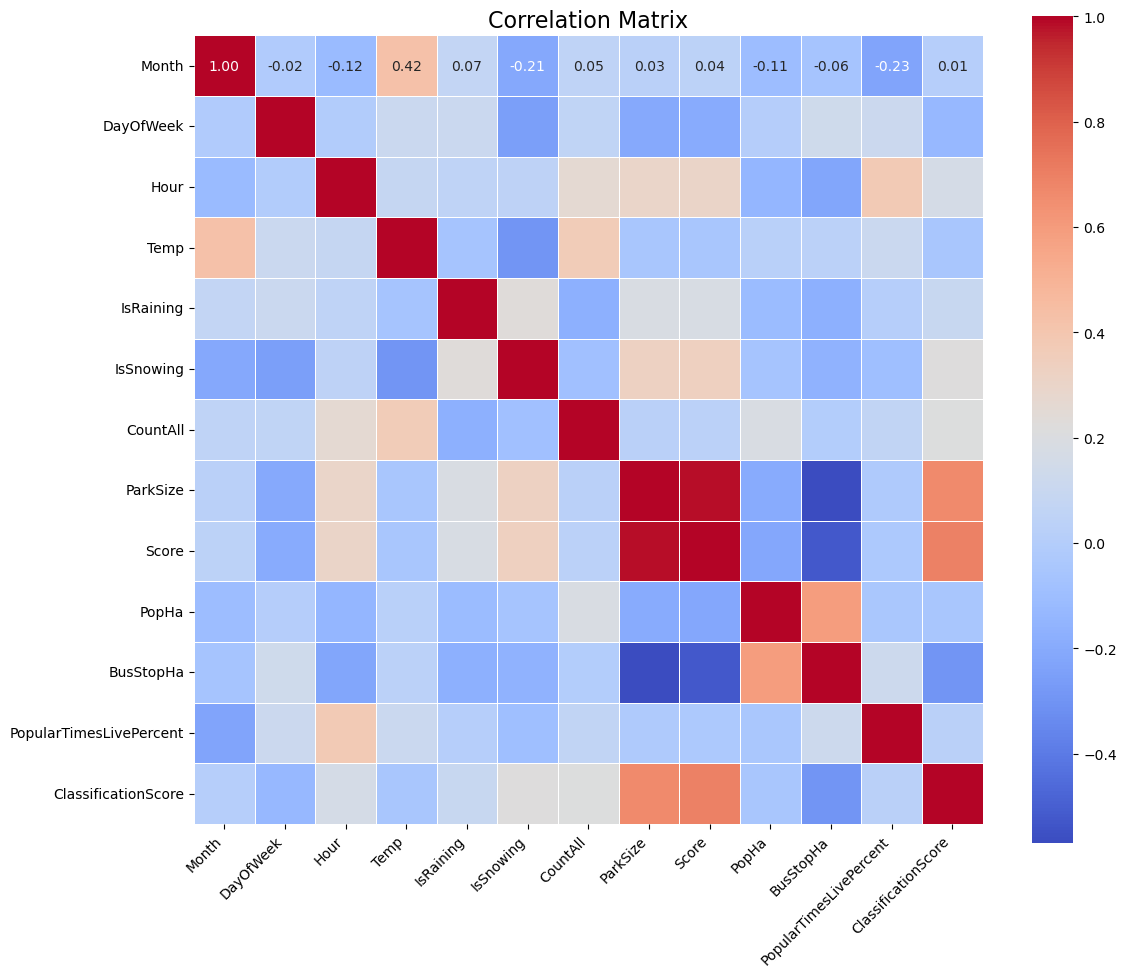

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ensure no NaNs in correlation matrix
numeric_cols = df.select_dtypes(include=['float64', 'int']).columns
corr = df[numeric_cols].corr().fillna(0)  # fill NaNs if any

plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)

# Optional: Rotate axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 51, Finished, Available, Finished)

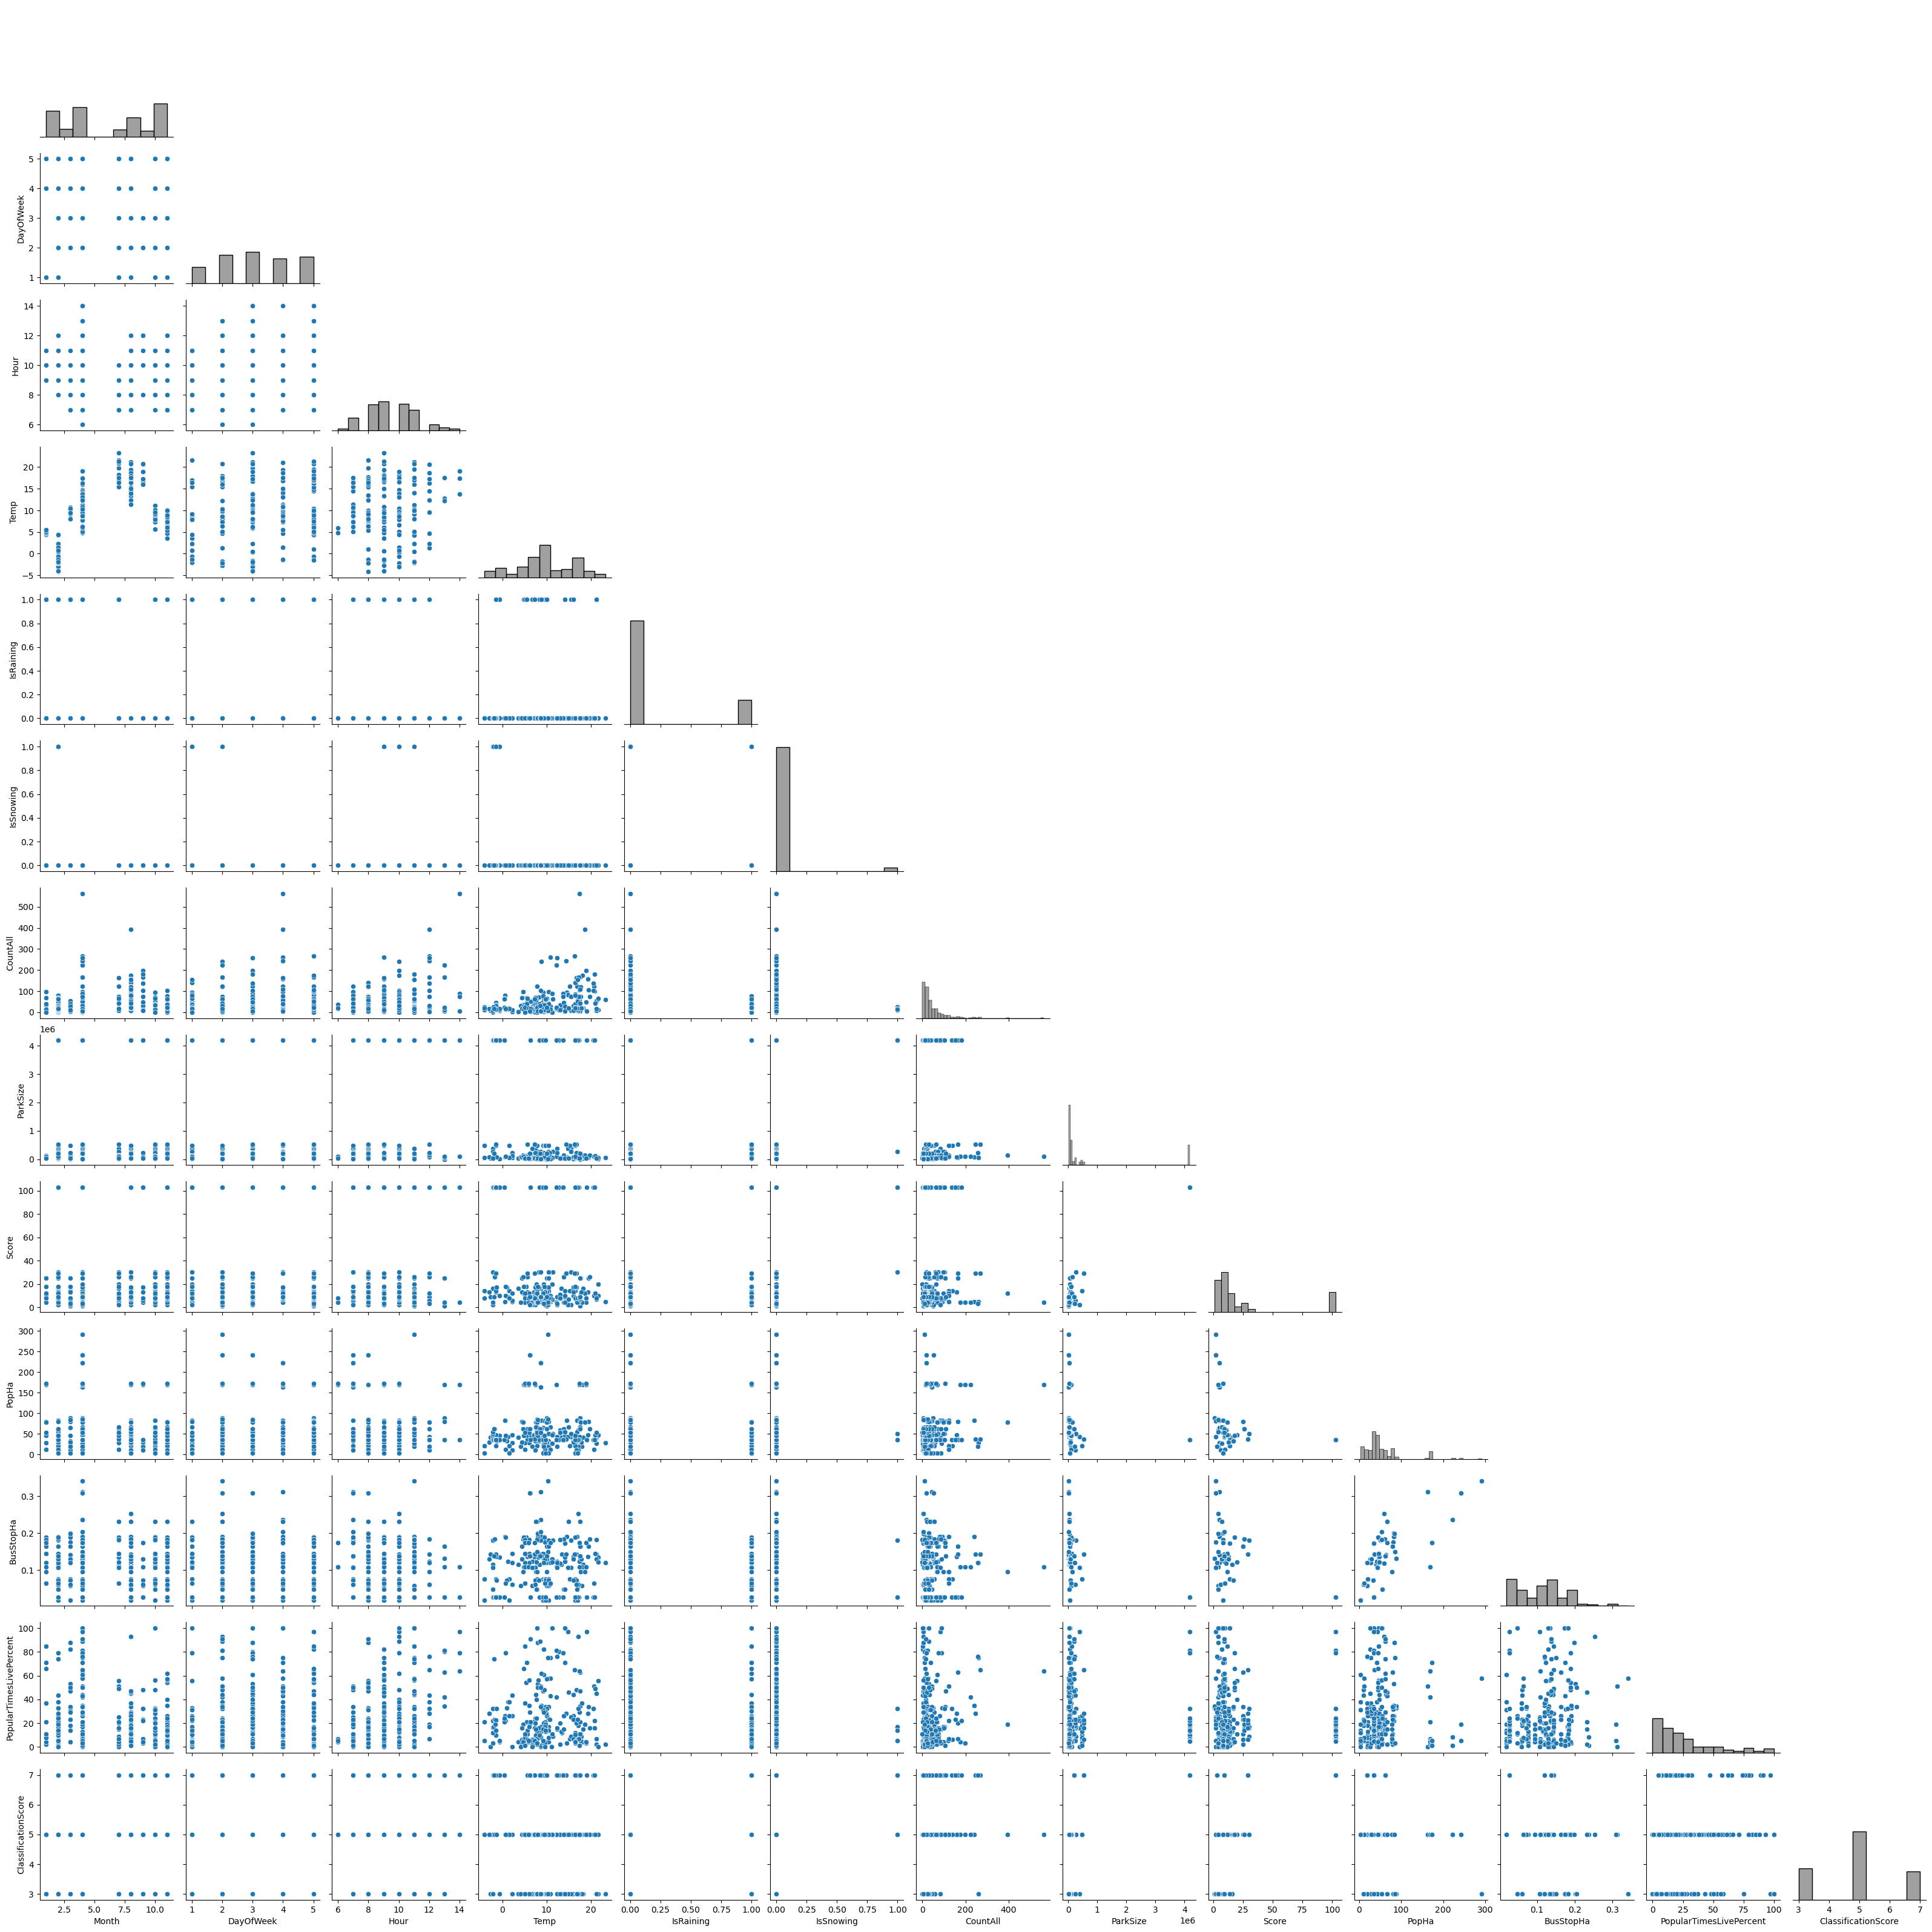

In [19]:
# Show Pairwise Plot
sns.pairplot(df[numeric_cols], 
             diag_kind='hist', corner=True, diag_kws={'color': 'grey'})
plt.yticks(rotation=0)
plt.show()

# Train ML Classification Model

## 1. Simple Model vs. Enhanced (with temporal features): Baseline Fit

In [20]:
simple_features = [
    'PopularTimesLivePercent', 'ParkSize', 'Score', 'ClassificationScore', 'BusStopHa', 'PopHa'
]

enhanced_features = simple_features + [
    'Temp', 'IsRaining', 'IsSnowing'
]

target = 'CountAll'

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 52, Finished, Available, Finished)

In [21]:
X_simple = df[simple_features].drop_duplicates()
y_simple = df.loc[X_simple.index, target]  # Align y with deduplicated X

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 53, Finished, Available, Finished)

In [22]:
X_enhanced = df[enhanced_features].drop_duplicates()
y_enhanced = df.loc[X_enhanced.index, target]  # Align y with deduplicated X

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 54, Finished, Available, Finished)

In [23]:
from sklearn.model_selection import train_test_split

# Split for simple model
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Split for enhanced model
X_enhanced_train, X_enhanced_test, y_enhanced_train, y_enhanced_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 55, Finished, Available, Finished)

In [24]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(pipe, X, y, label="Model"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(pipe, X, y, cv=kf)

    print(f"\n----- {label} -----")
    print(f"MAE  : {mean_absolute_error(y, y_pred):.2f}")
    print(f"RMSE : {mean_squared_error(y, y_pred, squared=False):.2f}")
    print(f"R²   : {r2_score(y, y_pred):.3f}")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 56, Finished, Available, Finished)

In [25]:
# Since parkClassScore is already numeric, we remove it from categorical_cols
categorical_cols = []  # No categoricals needing one-hot encoding now

# Update numeric feature lists
numeric_cols_simple = [f for f in simple_features]
numeric_cols_enhanced = [f for f in enhanced_features]

# Define preprocessors (pass-through only)
simple_preprocessor = ColumnTransformer([
    # No categorical transformations
], remainder='passthrough')

enhanced_preprocessor = ColumnTransformer([
    # No categorical transformations
], remainder='passthrough')

# Define model pipelines
simple_pipe = Pipeline([
    ('prep', simple_preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

enhanced_pipe = Pipeline([
    ('prep', enhanced_preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Fit and evaluate
evaluate_model(simple_pipe, X_simple, y_simple, label="Simple Model")
evaluate_model(enhanced_pipe, X_enhanced, y_enhanced, label="Enhanced Model")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 57, Finished, Available, Finished)


----- Simple Model -----
MAE  : 44.30
RMSE : 73.68
R²   : -0.213



----- Enhanced Model -----
MAE  : 35.96
RMSE : 63.07
R²   : 0.081


## 2. Simple Model vs. Enhanced (with temporal features): with Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV, KFold

# Define parameter grid
param_grid = {
    'model__n_estimators'     : [100, 200],     # fewer trees
    'model__max_depth'        : [2, 3, 5],       # shallower trees reduce overfitting
    'model__learning_rate'    : [0.05, 0.1],     # 0.03 may be too slow with limited data
    'model__subsample'        : [0.8],           # fixed to reduce variance
    'model__colsample_bytree' : [0.8, 1.0],      # test both
}

# Preprocessor (pass-through only, since no categorical)
simple_preprocessor = ColumnTransformer([], remainder='passthrough')
enhanced_preprocessor = ColumnTransformer([], remainder='passthrough')

# Pipelines
simple_pipe = Pipeline([
    ('prep', simple_preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

enhanced_pipe = Pipeline([
    ('prep', enhanced_preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Cross-validation folds
k = min(5, len(X_simple)) if len(X_simple) > 1 else 2
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search for simple model
grid_simple = GridSearchCV(
    estimator=simple_pipe,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_simple.fit(X_simple_train, y_simple_train)

# Grid search for enhanced model
grid_enhanced = GridSearchCV(
    estimator=enhanced_pipe,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_enhanced.fit(X_enhanced_train, y_enhanced_train)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 58, Finished, Available, Finished)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=Fa...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [2, 3, 5],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8]},
             scoring='neg_mean_absolute_error', verbose=1)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def report_results(grid, X_train, y_train, X_test, y_test, label):
    print(f"\n===== {label} - Best Params =====")
    print(grid.best_params_)
    print(f"Best CV MAE: {-grid.best_score_:.2f} visitors")

    best_model = grid.best_estimator_
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred  = best_model.predict(X_test)

    print(f"----- {label} - Training Metrics -----")
    print(f"MAE  : {mean_absolute_error(y_train, y_train_pred):.2f}")
    print(f"RMSE : {mean_squared_error(y_train, y_train_pred, squared=False):.2f}")
    print(f"R²   : {r2_score(y_train, y_train_pred):.3f}")

    print(f"----- {label} - Test Metrics -----")
    print(f"MAE  : {mean_absolute_error(y_test, y_test_pred):.2f}")
    print(f"RMSE : {mean_squared_error(y_test, y_test_pred, squared=False):.2f}")
    print(f"R²   : {r2_score(y_test, y_test_pred):.3f}")


StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 59, Finished, Available, Finished)

In [28]:
report_results(
    grid_simple, 
    X_simple_train, y_simple_train,
    X_simple_test,  y_simple_test,
    label="Simple Model"
)

report_results(
    grid_enhanced, 
    X_enhanced_train, y_enhanced_train,
    X_enhanced_test,  y_enhanced_test,
    label="Enhanced Model"
)


StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 60, Finished, Available, Finished)


===== Simple Model - Best Params =====
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best CV MAE: 41.40 visitors
----- Simple Model - Training Metrics -----
MAE  : 29.11
RMSE : 44.60
R²   : 0.610
----- Simple Model - Test Metrics -----
MAE  : 34.09
RMSE : 50.64
R²   : -0.389

===== Enhanced Model - Best Params =====
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best CV MAE: 31.12 visitors
----- Enhanced Model - Training Metrics -----
MAE  : 10.99
RMSE : 14.88
R²   : 0.951
----- Enhanced Model - Test Metrics -----
MAE  : 25.99
RMSE : 50.55
R²   : 0.249


## Test Prediction

In [29]:
test_input_simple = {
    'ClassificationScore': 3,         # Numerical encoding of Classification
    'Score': 9,
    'ParkSize': 44420,
    'PopHa': 41,
    'BusStopHa': 0.14,
    'PopularTimesLivePercent': 2
}

test_input_enhanced = {
    'ClassificationScore': 3,
    'Score': 9,
    'ParkSize': 44420,
    'PopHa': 41,
    'BusStopHa': 0.14,
    'PopularTimesLivePercent': 2,
    'Temp': 21.3,
    'IsRaining': 1,
    'IsSnowing': 0
}

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 61, Finished, Available, Finished)

In [30]:
def predict_with_ci(model_pipeline, input_dict):
    """
    Predict visitor count with 95% CI using XGBoost per-tree predictions,
    while ensuring correct preprocessing via the pipeline.
    """
    input_df = pd.DataFrame([input_dict])

    # Ensure full preprocessing using pipeline
    X_transformed = model_pipeline.named_steps['prep'].transform(input_df)

    # Extract trained XGBoost model
    xgb_model = model_pipeline.named_steps['model']
    booster = xgb_model.get_booster()

    # Convert to DMatrix
    dmatrix = xgb.DMatrix(X_transformed, enable_categorical=False)

    # Predict from each tree
    n_trees = xgb_model.n_estimators
    preds = np.array([
        booster.predict(dmatrix, iteration_range=(i, i + 1))[0]
        for i in range(n_trees)
    ])

    mean_pred = preds.mean()
    std_pred = preds.std()
    lower = mean_pred - 1.96 * std_pred
    upper = mean_pred + 1.96 * std_pred

    return round(mean_pred), round(lower), round(upper)

# Example: simple model
mean_pred, lower_ci, upper_ci = predict_with_ci(grid_simple.best_estimator_, test_input_simple)
print(f"Simple Model Prediction: {mean_pred} visitors (95% CI: {lower_ci} to {upper_ci})")

# Example: enhanced model
mean_pred, lower_ci, upper_ci = predict_with_ci(grid_enhanced.best_estimator_, test_input_enhanced)
print(f"Enhanced Model Prediction: {mean_pred} visitors (95% CI: {lower_ci} to {upper_ci})")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 62, Finished, Available, Finished)

Simple Model Prediction: 52 visitors (95% CI: 51 to 52)
Enhanced Model Prediction: 51 visitors (95% CI: 49 to 53)


In [31]:
def predict_visitors(model_pipeline, input_dict):
    input_df = pd.DataFrame([input_dict])

    # Apply the same preprocessing step as the pipeline
    X_transformed = model_pipeline.named_steps['prep'].transform(input_df)

    # Predict using trained XGBoost model
    pred = model_pipeline.named_steps['model'].predict(X_transformed)[0]
    return round(pred)

# Simple model prediction
simple_pred = predict_visitors(grid_simple.best_estimator_, test_input_simple)
print(f"Simple Model Prediction: {simple_pred} visitors")

# Enhanced model prediction
enhanced_pred = predict_visitors(grid_enhanced.best_estimator_, test_input_enhanced)
print(f"Enhanced Model Prediction: {enhanced_pred} visitors")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 63, Finished, Available, Finished)

Simple Model Prediction: 14 visitors
Enhanced Model Prediction: 45 visitors


## Save Trained Model

In [ ]:
import joblib
import os
from sklearn.metrics import mean_absolute_error

# Compute MAE on test set
mae_test = mean_absolute_error(y_enhanced_test, grid_enhanced.best_estimator_.predict(X_enhanced_test))

# Package model and MAE in a dictionary
model_artifact = {
    'model': grid_enhanced.best_estimator_,
    'mae_test': mae_test
}

# Define Lakehouse path
model_dir = "/lakehouse/default/Files/models/user_estimates"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "user_estimates_model.joblib")

# Save the combined artifact
joblib.dump(model_artifact, model_path)
print(f"Model and MAE saved to {model_path}")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 64, Finished, Available, Finished)

Model and MAE saved to /lakehouse/default/Files/models/user_estimates/user_estimates_model.joblib


In [32]:
# import joblib
# import os

# model_dir = "/lakehouse/default/Files/models/user_estimates"
# os.makedirs(model_dir, exist_ok=True)
# model_path = os.path.join(model_dir, "user_estimates_model.joblib")

# # Save the best estimator from GridSearchCV
# joblib.dump(grid_enhanced.best_estimator_, model_path)
# print(f"Model saved to {model_path}")

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 65, Finished, Available, Finished)

## Log Model Summary

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from datetime import datetime

# Define schema
schema = StructType([
    StructField("TimeStamp", StringType(), True),
    StructField("MAE", DoubleType(), True),
    StructField("RMSE", DoubleType(), True),
    StructField("R_squared", DoubleType(), True),
    StructField("BestParams", StringType(), True)
])

# Table name
table_name = "user_estimates_model_summary"

# Create table if it doesn't exist
if not spark.catalog.tableExists(table_name):
    empty_df = spark.createDataFrame([], schema)
    empty_df.write.mode("overwrite").saveAsTable(table_name)

# Prepare metrics (ensure float conversion)
y_pred_test = grid_enhanced.best_estimator_.predict(X_enhanced_test)
mae = round(float(mean_absolute_error(y_enhanced_test, y_pred_test)), 2)
rmse = round(float(mean_squared_error(y_enhanced_test, y_pred_test, squared=False)), 2)
r2 = round(float(r2_score(y_enhanced_test, y_pred_test)), 3)
best_params = str(grid_enhanced.best_params_)

# Construct row as plain Python dict with native types
data = [{
    "TimeStamp": datetime.now().isoformat(),
    "MAE": mae,
    "RMSE": rmse,
    "R_squared": r2,
    "BestParams": best_params
}]

# Create and append to table
summary_df = spark.createDataFrame(data, schema=schema)
summary_df.write.mode("append").saveAsTable(table_name)

StatementMeta(, 5275b0d2-13f0-4164-bc00-647a71b04116, 66, Finished, Available, Finished)